This Notebook is mainly an exploratory analysis of the Hearthstone Dataset. The main focus is to clean and sort the data in order to make further analysis more efficient.

In [2]:
## All the Libraries used

import os
import numpy as np
import json
import pandas as pd
from collections import Counter
import csv
import matplotlib.pyplot as plt
from sklearn import neighbors, metrics, grid_search, cross_validation
import matplotlib.pyplot as plt
##import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model
import sklearn
from sklearn.ensemble import RandomForestRegressor



pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline

plt.style.use('ggplot')

In [3]:
## reading heartpwn dataset

data_df = pd.read_csv(os.path.join('data.csv'))
data_df

,craft_cost,date,deck_archetype,deck_class,deck_format,...,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,...,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,...,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,...,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,...,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,...,374,2717,2717,2889,2889
...,...,...,...,...,...,...,...,...,...,...,...
346227,5480,2016-04-25,Unknown,Paladin,S,...,38745,38781,38781,38911,38911
346228,3840,2016-02-07,Unknown,Rogue,S,...,1158,1372,1651,2884,2884
346229,5580,2016-02-07,Unknown,Paladin,W,...,2883,2889,2901,2949,2951
346230,5160,2016-02-07,Unknown,Druid,S,...,2782,2782,2948,38319,38319


In [4]:
## reading card dataset

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

In [5]:
data_df['date'] = pd.to_datetime(data_df['date'])

# Primary Analysis

In [6]:
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'S'))
print np.average(data_df.craft_cost, weights=(data_df.deck_format == 'W'))

6020.33807806
5280.34209956


On average, Standard decks cost more dust than Wild decks.

In [7]:
Counter(data_df.deck_format)

Counter({'S': 170786, 'W': 175446})

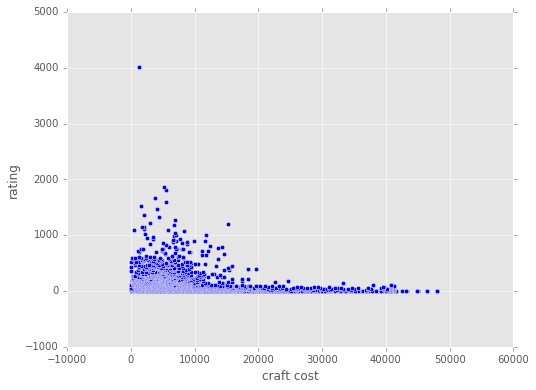

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(data_df.craft_cost, np.sort(data_df.rating.values))
plt.xlabel('craft cost', fontsize=12)
plt.ylabel('rating', fontsize=12)
plt.show()

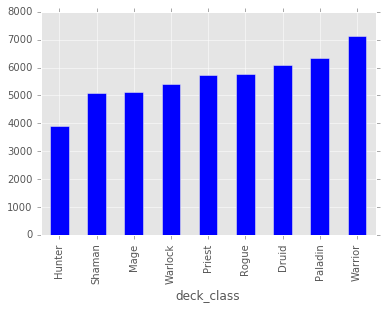

In [16]:
c = data_df.craft_cost.groupby(data_df.deck_class).mean()
c.sort_values(inplace=True)
c.plot(kind = 'bar')

From the graph, Warrior decks often cost the most to craft, whilst Hunter decks are the cheapest

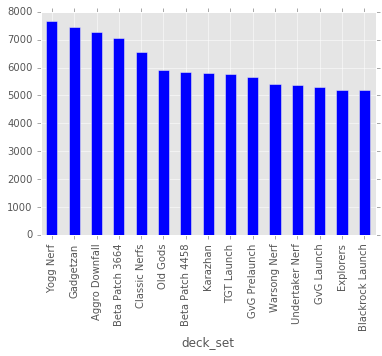

In [29]:
c = data_df.craft_cost.groupby(data_df.deck_set).mean()
c.sort_values(inplace=True, ascending = False)
c[:15].plot(kind = 'bar')

# Further Analysis


## Releases and meta

## Race

In [10]:
data_df = pd.read_csv(os.path.join('data.csv'))

with open('refs.json') as file:
    refs = json.load(file)

refs = pd.DataFrame(refs)

data_df['date'] = pd.to_datetime(data_df['date'])
refs.race.fillna('Normal', inplace=True)
data_df = data_df.drop(data_df.deck_type == 'Tavern Brawl')
refs.cost.fillna(0,inplace=True)

card_col = ['card_{}'.format(str(i)) for i in range(30)]

In [30]:
result = data_df.copy()
result = result.reset_index(drop = True)

for x in range(30):
    result = pd.merge(result, refs, left_on = result[card_col[x]], right_on = refs.dbfId, how = 'left')

In [ ]:
## creating Race columns and its sum

races = refs.race.unique()
race_df = pd.DataFrame(index=result.index)
for x in range(len(races)):
    race_df[races[x]] = 0
    
dum = [result['race_x'],result['race_y']]
    
for x in range(len(result)):
    out = Counter(dum[0].ix[x]) + Counter(dum[1].ix[x])
    for i in range(len(races)):
        race_df = race_df.set_value(x, races[i], out[races[i]])

In [ ]:
race_df['date'] = result.date
race_df['deck_set'] = result.deck_set

In [ ]:
rand_ex = race_df[race_df.deck_set == 'Explorers']
rand_og = race_df[race_df.deck_set == 'Old Gods']
rand_br = race_df[race_df.deck_set == 'Blackrock Launch']
rand_gadge = race_df[race_df.deck_set == 'Gadgetzan']
rand_kar = race_df[race_df.deck_set == 'Karazhan']
rand_naxx = race_df[race_df.deck_set == 'Naxx Launch']
rand_tgt = race_df[race_df.deck_set == 'TGT Launch']
rand_gvg = race_df[race_df.deck_set == 'GVG Launch']

race_df_groupby = race_df.groupby('deck_set')

In [ ]:
a = range(len(rand_ex.sum()))
b = rand_ex.mean()
plt.bar(a, b)

x = range(len(rand_og.sum()))
y = rand_og.mean()
my_xticks = rand_og.columns
plt.xticks(x, my_xticks, rotation = 'vertical')
plt.bar(x, y)


plt.show()



In [ ]:
lol = rand_og.drop('Normal', axis = 1)

x = range(len(lol.sum()))
y = lol.mean()
my_xticks = lol.columns
plt.xticks(x, my_xticks, rotation = 'vertical')
plt.bar(x, y)


plt.show()


In [ ]:
lol = rand_og.drop('Normal', axis = 1)

x = range(len(lol.sum()))
y = lol.mean()
my_xticks = lol.columns
plt.pie(x, y)


plt.show()


In [ ]:
test = race_df.groupby(race_df.deck_set)

In [ ]:
Counter(race_df.deck_set).most_common(15)

In [ ]:
trial = race_df.copy()

In [ ]:
threshold = 5000 # Anything that occurs less than this will be removed.
value_counts = trial['deck_set'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= threshold].index
trial['deck_set'].replace(to_remove, np.nan, inplace=True)
trial = trial.drop(data_df.deck_type == 'nan')


In [ ]:
Counter(trial.deck_set)

In [ ]:
Counter(race_df.deck_set)

In [ ]:
trial = trial.dropna(how = 'any')

In [ ]:
trial.groupby(trial.deck_set)

In [ ]:
data_df.columns

In [ ]:
refs.columns